In [38]:
# general imports
import sys
sys.path.append('/home/tplas/repos/Vape/')
sys.path.append('/home/tplas/repos/Vape/utils')
sys.path.append('/home/tplas/repos/Vape/jupyter/')
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import utils_funcs as utils
import run_functions as rf
from subsets_analysis import Subsets
import pickle
from dPCA import dPCA

In [2]:
%run setup_notebook.ipynb

ERROR:root:File `'setup_notebook.ipynb.py'` not found.


In [3]:
## Load data
pkl_path = '/mnt/qnap_jrowland/run_pkls'


# dictionary of mice and run numbers to analyse
run_dict = {
            'J048' : [27, 29, 30, 32], 
            'RL048': [23, 24, 25, 28, 29]
           }

# local path to behaviour pickle files
# this takes a while to load so maybe should do some further caching in the future
# pkl_path = '/home/jamesrowland/Documents/Code/Vape/run_pkls/'

runs = []
mouse = 'J048'
run_number = 27
# for run_number in run_dict[mouse]:
print(f'Now loading mouse {mouse}, run {run_number}')
run_path = os.path.join(pkl_path, mouse, 'run{}.pkl'.format(run_number))
with open(run_path, 'rb') as f:
    r = pickle.load(f)
    runs.append(r)

# runs = []
# for mouse in run_dict:
#     for run_number in run_dict[mouse]:
#         print(f'Now loading mouse {mouse}, run {run_number}')
#         run_path = os.path.join(pkl_path, mouse, 'run{}.pkl'.format(run_number))
#         with open(run_path, 'rb') as f:
#             r = pickle.load(f)
#             runs.append(r)

Now loading mouse J048, run 27


This run has 2101 cells and 16117 frames


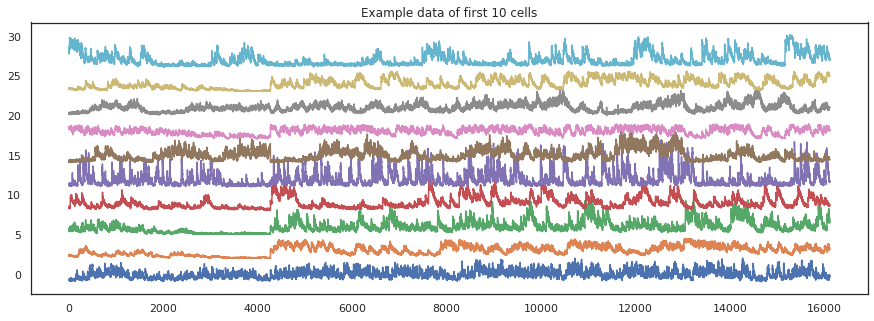

In [4]:
## Inspect data

# runs[0].__dict__.keys()

# processed (neuropil subtracted and Df/f) fluoresence matrix from first run
flu = runs[0].flu
print('This run has {} cells and {} frames'.format(flu.shape[0], flu.shape[1]))

# plot the first 10 cells in the first run
plt.figure(figsize=(15,5))
for i in range(10):
    plt.plot(flu[i,:] + i*3)
plt.title('Example data of first 10 cells')
# run objects have info from the suite2p stat (1xdictionary per cell
# used to e.g. find the plane each cell is in
plane0_idx = [idx for idx, s in enumerate(runs[0].stat) if s['iplane']==0]

# ## Find plane_0 neurons:
# # run objects have info from the suite2p stat (1xdictionary per cell
# # used to e.g. find the plane each cell is in
# plane0_idx = [idx for idx, s in enumerate(runs[0].stat) if s['iplane']==0]




In [5]:
# plt.rcParams['figure.figsize'] = (10, 10)
# plt.plot(galvo_ms / 1e6, trial_start[:] /1e6, '.-')
# print(run_number, mouse)
# # np.isnan(galvo_ms)
# runs[0].aligner.A_to_B
# -1
# trial_start.shape
# tstart_galvo.shape
# mouse, run_number

# runs[0].frames_ms.shape
# runs[0].flu.shape
# plt.imshow(np.isnan(runs[0].frames_ms))

In [6]:
## Align with  behaviour:
#### two timestamps for the onset of photostimulation ####

# when is voltage sent to the x photostimulation galvo
tstart_galvo = utils.threshold_detect(runs[0].x_galvo_uncaging, 0)

# when did the behaviour microcontroller trigger a trial start
trial_start = runs[0].trial_start
# if (run_number == 29 and mouse == 'J048') or (run_number == 29 and mouse == 'RL048'):
#     slope = (trial_start[-2] - trial_start[0]) / (tstart_galvo[-1] - tstart_galvo[0])
#     new_point = tstart_galvo[-1] + slope * (trial_start[-1] - trial_start[-2])
#     tstart_galvo = np.concatenate((tstart_galvo, new_point[np.newaxis]))

assert len(trial_start) == len(tstart_galvo)

#### these two timestamp variables are in a different reference frame ####

# run objects have an aligner method to switch between reference frames
galvo_ms = runs[0].aligner.B_to_A(tstart_galvo)

print('microcontroller trial starts occur on average {} ms from galvo trial starts'
      .format(round(np.mean(trial_start - galvo_ms), 2)))


assert runs[0].frames_ms.shape == runs[0].flu.shape

microcontroller trial starts occur on average -36.39 ms from galvo trial starts


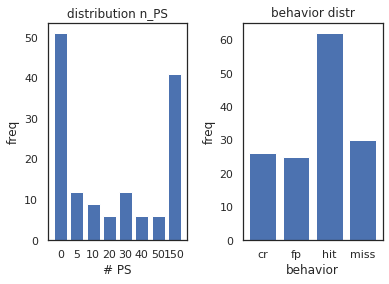

In [7]:
### a different number of cells were stimulated on each trial
### need to create a Subsets object to get this info (future code refinement will
### include this info directly in the run object
subsets = Subsets(runs[0])
trial_subsets = subsets.trial_subsets
# print(trial_subsets[5:20])
n_stim_arr = np.unique(trial_subsets)
plt.subplots_adjust(wspace=0.4)

plt.subplot(121)
plt.bar(np.arange(len(n_stim_arr)), height=[np.sum(trial_subsets == x) for x in n_stim_arr])
plt.xticks(np.arange(len(n_stim_arr)), (str(x) for x in n_stim_arr))
plt.xlabel("# PS"); plt.ylabel('freq'); plt.title('distribution n_PS')
### the result of the behavioural trial is in the run.oucome array

plt.subplot(122)
outcome = runs[0].outcome
outcome_arr = np.unique(outcome)
# print(outcome[5:20])
plt.bar(np.arange(len(outcome_arr)), height=[np.sum(outcome == x) for x in outcome_arr])
plt.xticks(np.arange(len(outcome_arr)), (str(x) for x in outcome_arr))
plt.xlabel('behavior'); plt.ylabel('freq'); plt.title('behavior distr')
assert len(runs[0].outcome) == len(tstart_galvo) == len(subsets.trial_subsets)


# licks = runs[0].session.times.get('lick_1')

In [8]:
# the number of frames before trial start to take into array
pre_frames = 15
# the number of frames after trial start to take into array
post_frames = 30
# array of fluoresence through behavioural trials (n_cells x n_trials x n_frames)
# with e.g. the first trials spanning (galvo_ms[0] - pre_frames) : (galvo_ms[0] + post_frames)
behaviour_trials = utils.build_flu_array(runs[0], galvo_ms, pre_frames, post_frames)
behaviour_trials = behaviour_trials - np.nanmean(behaviour_trials, (1, 2))[:, np.newaxis, np.newaxis]
print(f'Shape new array : {behaviour_trials.shape}')
assert behaviour_trials.shape[1] == outcome.shape[0]

Shape new array : (2101, 143, 45)


(2101, 143, 45) (2101, 10, 45)


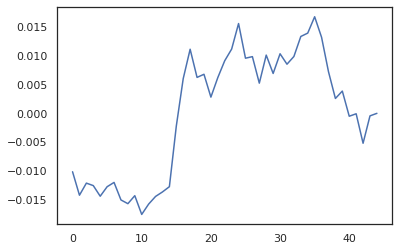

In [9]:
pre_rew_trials = utils.build_flu_array(runs[0], runs[0].pre_reward, pre_frames, 
                                       post_frames, is_prereward=True)
pre_rew_trials = pre_rew_trials - np.nanmean(pre_rew_trials, (1, 2))[:, np.newaxis, np.newaxis]
print(behaviour_trials.shape, pre_rew_trials.shape)
plt.plot(np.nanmean(pre_rew_trials, (0, 1)))

In [10]:
decision = np.logical_or(outcome == 'hit', outcome == 'fp').astype('int')
photostim = np.ones_like(trial_subsets)  # ones = 5-50
photostim[trial_subsets == 0] = 0
photostim[trial_subsets == 150] = 2
assert photostim.shape == decision.shape

In [11]:
n_unique_stims = len(np.unique(photostim))
n_neurons = behaviour_trials.shape[0]
n_times = behaviour_trials.shape[2]
n_trials = behaviour_trials.shape[1]
n_unique_dec = len(np.unique(decision))
occ_table = np.zeros((n_unique_stims, 2))  # stim x dec
for dec in range(n_unique_dec):
    for stim in range(n_unique_stims):
        occ_table[stim, dec] = np.sum(np.logical_and(decision == dec, photostim == stim))
n_com_trials = np.max(occ_table).astype('int')
print(occ_table)

[[26. 25.]
 [25. 26.]
 [ 5. 36.]]


In [12]:
art_gap_start = pre_frames - 1
art_gap_stop = pre_frames + 3

(2101, 25, 45)
(2101, 17, 45)
(2101, 4, 45)
(2101, 25, 45)
(2101, 26, 45)
(2101, 33, 45)
(33, 2101, 2, 2, 41)


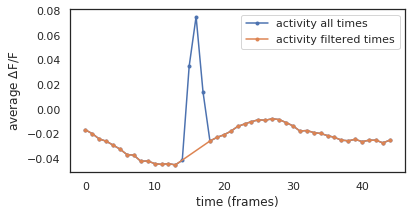

In [13]:
activity = np.zeros((n_com_trials, n_neurons, n_unique_stims, n_unique_dec, n_times))
activity = activity * np.nan
nan_trials = np.isnan(np.mean(behaviour_trials, (0, 2)))
min_common = 100
max_common = 0
for dec in range(n_unique_dec):
    for stim in range(n_unique_stims):
        inds_cond = np.logical_and(decision == dec, photostim == stim)
        inds_cond = np.logical_and(inds_cond, np.logical_not(nan_trials))
        current_data = np.squeeze(behaviour_trials[:, inds_cond, :])
        n_curr_trials = current_data.shape[1]
        activity[:n_curr_trials, :, stim, dec, :] = np.swapaxes(current_data, 0, 1)
        max_common = np.maximum(max_common, current_data.shape[1])
        min_common = np.minimum(min_common, current_data.shape[1])
        print(current_data.shape)
# n_com_trials = np.minimum(n_com_trials, min_common)
n_com_trials = np.minimum(n_com_trials, max_common)

activity = activity[:n_com_trials, :, :, :, :]
n_unique_stims = 2
activity = activity[:, :, :n_unique_stims, :, :]  # filter out PS = 150 trials
filter_ps_array = np.concatenate((np.arange(art_gap_start), 
                                  np.arange(art_gap_stop, pre_frames + post_frames)))  # filter out few frames around PS
old_act = activity.copy()
activity = activity[:, :, :, :, filter_ps_array]
activity = activity - np.nanmean(activity[:, :, :, :, :], (0, 2, 3, 4))[np.newaxis, :, np.newaxis, np.newaxis, np.newaxis]
# activity = activity / np.nanstd(activity[:, :, :, :, :], (0, 2, 3, 4))[np.newaxis, :, np.newaxis, np.newaxis, np.newaxis]
activity_av = np.nanmean(activity, 0)

plt.rcParams['figure.figsize'] = (6, 3)
plt.plot(np.nanmean(old_act, (0, 1, 2, 3)), '.-', label='activity all times')
plt.plot(filter_ps_array, np.nanmean(activity, (0, 1, 2, 3)), '.-', label='activity filtered times')
plt.legend(); plt.xlabel('time (frames)'); plt.ylabel('average $\Delta$F/F')
print(activity.shape)


In [14]:
dpca = dPCA.dPCA(labels='sdt', n_components=5, regularizer='auto')
dpca.protect = ['t']

You chose to determine the regularization parameter automatically. This can
                    take substantial time and grows linearly with the number of crossvalidation
                    folds. The latter can be set by changing self.n_trials (default = 3). Similarly,
                    use self.protect to set the list of axes that are not supposed to get to get shuffled
                    (e.g. upon splitting the data into test- and training, time-points should always
                    be drawn from the same trial, i.e. self.protect = ['t']). This can significantly
                    speed up the code.


In [15]:
# activity = activity[:, inds_pos_r2, :, :, :]
# activity_av = activity_av[inds_pos_r2, :, :, :]

In [16]:
Z = dpca.fit_transform(activity_av, activity)

Start optimizing regularization.
Starting trial  1 / 3
Starting trial  2 / 3
Starting trial  3 / 3
Optimized regularization, optimal lambda =  0.004743480741674971
Regularization will be fixed; to compute the optimal                    parameter again on the next fit, please                    set opt_regularizer_flag to True.


In [17]:
recon = {}
recon['st'] = (dpca.reconstruct(activity_av, marginalization='st').copy() +
               dpca.reconstruct(activity_av, marginalization='s').copy())
recon['dt'] = (dpca.reconstruct(activity_av, marginalization='dt').copy() +
               dpca.reconstruct(activity_av, marginalization='d').copy())
recon['sdt'] = (dpca.reconstruct(activity_av, marginalization='sdt').copy() +
               dpca.reconstruct(activity_av, marginalization='sd').copy())
recon['t'] = dpca.reconstruct(activity_av, marginalization='t').copy()
recon['full'] = np.zeros_like(recon['st'])
for cond in ['t', 'st', 'dt', 'sdt']:
    recon['full'] += recon[cond]
    
tmp = dpca.transform(activity_av, marginalization=None)  # call this function to recompute explained_variance_ratio_ (for something reason/buggy this is reset upon every marginalizaiton for all dimensions that are not the marginalization)

save_fig = False

<Figure size 864x936 with 0 Axes>

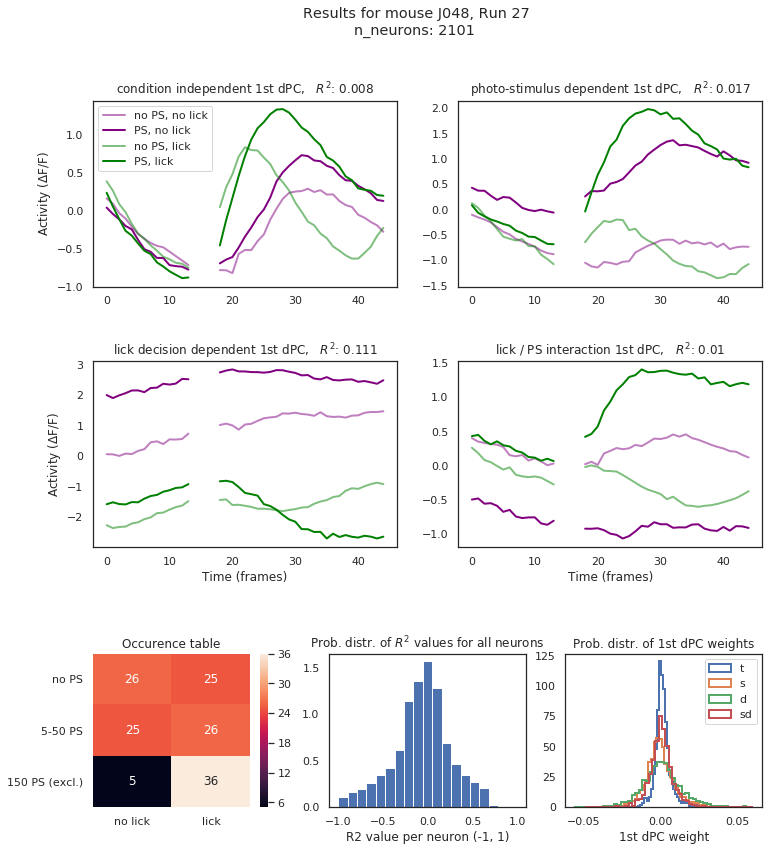

In [18]:
dec_color = {0: 'purple', 1: 'green'}
stim_alpha = {0: 0.5, 1: 1, 2: 1}
title_cond = {'t': 'condition independent', 's': 'photo-stimulus dependent',
              'd': 'lick decision dependent', 'sd': 'lick / PS interaction'}
label_cond = {'stim': {0: 'no PS', 1: 'PS'}, 'dec': {0: 'no lick', 1: 'lick'}}
i_pc = 0  # what dPC to plot

def plot_condition(ax, cond):
    """Function to plot 1 condition on axis object ax"""
    for dec in range(n_unique_dec):  # loop through all conditions
        for stim in range(n_unique_stims):
            plot_array = None
            plot_array = Z[cond][i_pc, stim, dec, :].copy()  # data to plot
            expl_var = dpca.explained_variance_ratio_[cond][i_pc].copy()  # extra 
            if cond != 't':
                plot_array += Z[cond + 't'][i_pc, stim, dec, :].copy()
                expl_var += dpca.explained_variance_ratio_[cond + 't'][i_pc].copy()
            ax.plot(filter_ps_array[:art_gap_start],
                    plot_array[:art_gap_start], label=f'{label_cond["stim"][stim]}, {label_cond["dec"][dec]}',
                     c=dec_color[dec], alpha=stim_alpha[stim], linewidth=2)
            ax.plot(filter_ps_array[art_gap_start:],
                    plot_array[art_gap_start:], #label=f'{label_cond["stim"][stim]}, {label_cond["dec"][dec]}',
                     c=dec_color[dec], alpha=stim_alpha[stim], linewidth=2)
    if i_row == 1:
        ax.set_xlabel('Time (frames)'); 
    if i_col == 0:
        ax.set_ylabel('Activity ($\Delta$F/F)'); 
    ax.set_title(title_cond[cond] + f' {i_pc + 1}st dPC,   $R^2$: {np.round(expl_var, 3)}')
    if i_row == 0 and i_col == 0:
        ax.legend()
        
plt.rcParams['figure.figsize'] = (12, 13)
plt.subplots_adjust(hspace=0.6, wspace=0.4)
fig, axes = plt.subplots(3, 2, gridspec_kw={'hspace': 0.4})

for i_row in range(2):
    for i_col in range(2):
        plot_condition(axes[i_row][i_col], list(title_cond.keys())[2 * i_row + i_col])
        
plt.subplot(4, 3, 10)
sns.heatmap(occ_table, annot=True, xticklabels=['no lick', 'lick'], 
            yticklabels=['no PS', '5-50 PS', '150 PS (excl.)'])
plt.yticks(rotation=0)
b, t = plt.ylim() # correct for default cut off
b += 0.5 # see https://github.com/mwaskom/seaborn/issues/1773
t -= 0.5 # 
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.title('Occurence table')

plt.subplot(4, 3, 11)
r2_dpca =  1- (np.mean(np.power(activity_av - recon['full'], 2), (1, 2, 3)) /
            np.mean(np.power(activity_av - np.mean(activity_av, 3)[:, :,:, np.newaxis], 2), (1, 2, 3)))
plt.hist(r2_dpca, bins=np.linspace(-1, 1, 20), density=True);
plt.xlabel('R2 value per neuron (-1, 1)'); plt.title('Prob. distr. of $R^2$ values for all neurons')
# print(np.argsort(r2_dpca)[-5:])
# print(r2_dpca[33])
# plt.xlim([0, 1])

plt.subplot(4, 3, 12)
plt.hist(dpca.D['t'][:, i_pc], bins=50, label='t',
        histtype='step', linewidth=2, density=True);
for cond in ['s', 'd', 'sd']:
    plt.hist((dpca.D[cond] + dpca.D[cond + 't'])[:, i_pc], bins=50, label=cond,
            histtype='step', linewidth=2, density=True);
plt.title(f'Prob. distr. of {i_pc + 1}st dPC weights')
plt.legend(); plt.xlabel(f'{i_pc + 1}st dPC weight'); #plt.ylabel('PDF')

plt.suptitle(f'Results for mouse {mouse}, Run {run_number}\n' \
             f'n_neurons: {activity.shape[1]} ');
if save_fig:
    plt.savefig(f'dPCA_results/dPCA_{mouse}_{run_number}.pdf') 
    save_fig = False

In [19]:
activity.shape

(33, 2101, 2, 2, 41)

### use sklearn metric for automated variance weighing
### total r2? -> sum of individual r2 values?



In [20]:
def angle_vectors(v1, v2):
    v1, v2 = np.squeeze(v1), np.squeeze(v2)
    assert v1.shape == v2.shape
    rad = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
    return rad * 360 / (2 * np.pi)

angle_vectors(dpca.D['s'][:, 0] + dpca.D['st'][:, 0],
             dpca.D['s'][:, 3] + dpca.D['st'][:, 3])


# np.arccos(0)

92.48681094167495

In [21]:
inds_pos_r2 = np.where(r2_dpca > 0.1)[0]
print(f'Fraction of R2 > 0 neurons: {np.round(inds_pos_r2.size / r2_dpca.size, 3)}')

total_abs_1st_w = np.zeros_like(dpca.D['t'][:, 0], dtype=np.float32)
for k in dpca.D.keys():
    total_abs_1st_w += np.abs(dpca.D[k][:, 0])

Fraction of R2 > 0 neurons: 0.256


(-1, 1)

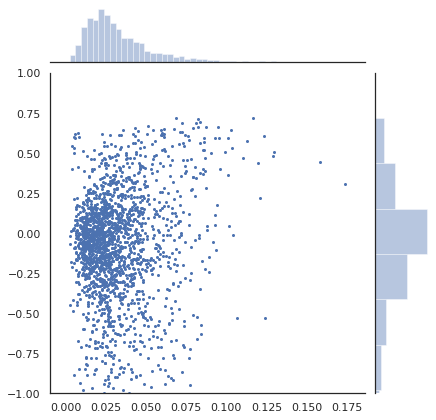

In [22]:
sns.jointplot(total_abs_1st_w, r2_dpca, s=4)
plt.ylim([-1, 1])

(2101,)


Text(0, 0.5, 'd')

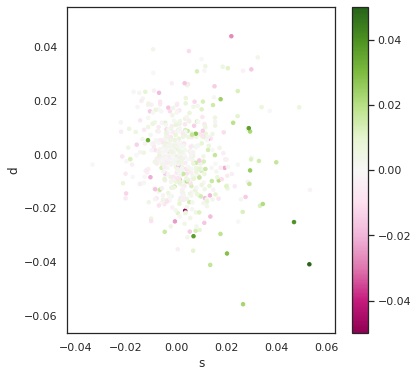

In [42]:
print((dpca.D['s'] + dpca.D['st'])[:, 0].shape)

plt.rcParams['figure.figsize'] = (6, 6)
# inds_pos_r2 = np.where(r2_dpca > 0)[0]
# sns.jointplot((dpca.D['s'] + dpca.D['st'])[inds_pos_r2, 0],
#             (dpca.D['d'] + dpca.D['dt'])[inds_pos_r2, 0], s=6)

def scale_arr_01(arr):
    arr = np.squeeze(arr)
    return (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

w_pc_s = (dpca.D['s'] + dpca.D['st'])[inds_pos_r2, 0]
w_pc_d = (dpca.D['d'] + dpca.D['dt'])[inds_pos_r2, 0]
w_pc_sd = ((dpca.D['sd'] + dpca.D['sdt'])[inds_pos_r2, 0])
plt.scatter(w_pc_s, w_pc_d, c=w_pc_sd,
             s=12, cmap='PiYG', vmin=-0.05, vmax=0.05);
plt.colorbar(); plt.xlabel('s');plt.ylabel('d')

# tmp_f = plt.figure()
# ax_3d = tmp_f.add_subplot(111, projection='3d')

# ax_3d.scatter(w_pc_s, w_pc_d, w_pc_sd)

There are 3 neurons that confirm
R2 of neuron 1919: 0.305


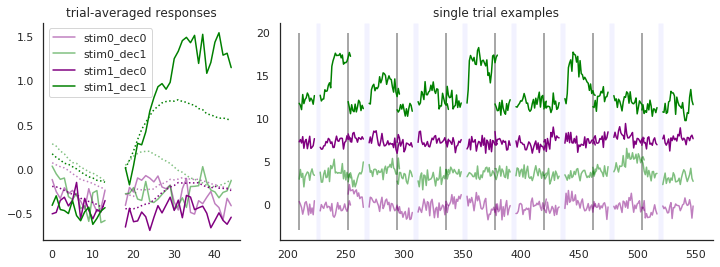

In [74]:
neuron_id = inds_pos_r2[np.where(w_pc_d < -0.04)[0]]  # lick, no ps
# neuron_id = inds_pos_r2[np.where(np.logical_and(w_pc_d < -0.02, w_pc_sd > 0.03))[0]] # only lick when stim
# neuron_id = inds_pos_r2[np.where(np.logical_and(np.logical_and(w_pc_s > 0.04, w_pc_d > 0.03),
#                                     w_pc_sd > 0.03))[0]]  # just weird

if len(neuron_id) == 1:
    neuron_id = neuron_id[0]
else:
    print(f'There are {len(neuron_id)} neurons that confirm')
    neuron_id = neuron_id[2]

plt.rcParams['figure.figsize'] = (12, 4)
plt.subplot(131)
for stim in [0, 1]:
    for dec in [0, 1]:
        plt.plot(filter_ps_array[:art_gap_start], activity_av[neuron_id, stim, dec, :art_gap_start], 
                 label=f'stim{stim}_dec{dec}', c=dec_color[dec], alpha=stim_alpha[stim])
        plt.plot(filter_ps_array[:art_gap_start], recon['full'][neuron_id, stim, dec, :art_gap_start], 
                 c=dec_color[dec], alpha=stim_alpha[stim], linestyle=':')
        
        plt.plot(filter_ps_array[art_gap_start:], activity_av[neuron_id, stim, dec, art_gap_start:], 
                 c=dec_color[dec], alpha=stim_alpha[stim])
        plt.plot(filter_ps_array[art_gap_start:], recon['full'][neuron_id, stim, dec, art_gap_start:], 
                 c=dec_color[dec], alpha=stim_alpha[stim], linestyle=':')
        
plt.legend();
plt.title('trial-averaged responses')

plt.subplot(1, 3, (2, 3))
for n_example in range(5, 13):
    y_shift = 0
    x_shift = (len(filter_ps_array) + 1) * n_example
    for stim in [0, 1]:
        for dec in [0, 1]:
            plt.plot(filter_ps_array[:art_gap_start] + x_shift, 
                     activity[n_example, neuron_id, stim, dec, :art_gap_start] + y_shift, 
                     c=dec_color[dec], alpha=stim_alpha[stim])
            plt.plot(filter_ps_array[art_gap_start:] + x_shift, 
                     activity[n_example, neuron_id, stim, dec, art_gap_start:] + y_shift, 
                     c=dec_color[dec], alpha=stim_alpha[stim])
            y_shift += 4
    plt.vlines(x=x_shift, ymax=20, ymin=-3, alpha=0.5)
    plt.axvspan(art_gap_start + x_shift, art_gap_stop + x_shift,
                facecolor='blue', alpha=0.05)
plt.title('single trial examples')
sns.despine()
print(f'R2 of neuron {neuron_id}: {np.round(r2_dpca[neuron_id], 3)}')

##### Look at these three:
 - s=0, d>0.07, sd < -0.03
 
 - s>0.04, d>0.03, sd>0.03
 
 - s>0.05, d~-0.01, sd>0.03